In [0]:
# import necessary libraries

import sklearn.datasets as ds
import matplotlib.pyplot as plt
import random
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms

# 1. Introduction to Linear Regression 

Linear regression is a predictive model. 
It is the simplest predictive model with the highest interpretability.

## 1.1 Mathematical formulas
Mathematically, **univariate** linear regression (one output) involves the following simple formula:
$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \epsilon$$
where $(x_1,...,x_p)$ are explanatory variables (also called features), $(\beta_0,\beta_1,...,\beta_p)$ are parameters measuring effects of each explanatory variable to response variable and $\epsilon$ is unobservable random error following normal distribution with mean zero and finite variance.

For **multivariate** linear regression (multiple outputs), equation above can be expressed using matrix:
$$Y = X\beta + \epsilon$$
where 
$$Y = \begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix}, \quad X = 
\begin{pmatrix} 
1 & x_{11} & ... & x_{n1} \\
1 & x_{21} & ... & x_{n2} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & ... & x_{np}
\end{pmatrix}, \quad \beta = \begin{pmatrix}
\beta_{0} \\
\beta_{1} \\
\vdots \\
\beta_p
\end{pmatrix} \quad\text{and} \quad \epsilon = \begin{pmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n \\
\end{pmatrix}.$$
Note that in the above, we assume that $n$ observations and $p$ features.
So, $X$ is an $n\times(p+1)$ matrix.

In linear regression, the main aim is to choose paramters $\beta$ so that the residual sum of squares (RSS) is minimized:
$$RSS = \| y - \hat{y} \|^2_2 = \| y - X\beta \|_2^2$$
where $y$ is the vector of observed values, $\hat{y}$ is the vector of predicted values by the linear regression model and 
$$\| (x_1,...,x_n) \|_2^2 = \sum_{i=1}^n |x_i|^2 \quad (\text{Euclidean distance}).$$
Since $\|x\|_2^2 = x^Tx,$ applying calculus to minimize RSS leads to 
$$\beta = (X^TX)^{-1} X^T y.$$

## 1.2 Assumptions of Linear Regression

Even though linear regression has the highest interpretability among all predictive models, it comes with several assumptions.
They are:

1. Linear relationship between explanatory and response variables.

2. Little or no multicollinearity among explanatory variables.

3. Residuals follow a normal distribution.

4. Little or no autocorrelation in the residuals.

5. Residuals have constant variance.

In the following sections, we will use synthetic dataset to verify the assumptions above.

## 1.2.1. Determine linear relationship by scatter plot

To check existence of linear relationship between explanatory variable and response variable, one can inspect **scatter plot** of collected data.

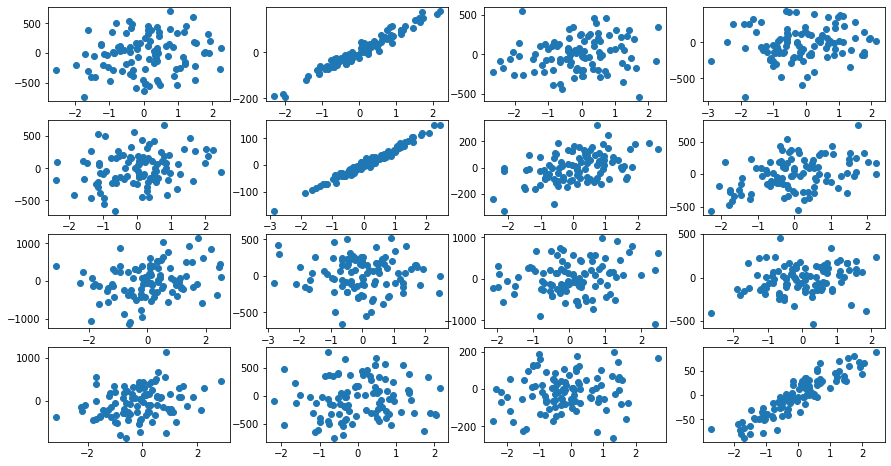

In [109]:
# univarate linear regression
n_features = 1

num_rows = 4
num_cols = 4
num_graphs = num_rows * num_cols

random.seed(10)

_, ax = plt.subplots(num_rows, num_cols, figsize = (15,8))


for i in range(num_graphs):
  # generate regression dataset
  X,y = ds.make_regression(n_samples=100, n_features=1, noise=random.randint(1,500), random_state=i)

  # plot regression dataset
  ax[i//num_cols, i%num_cols].scatter(X,y)

By inspecting all scatter plots above, it seems that only three plots have linear relasionship whereas the remaining plots do not have linear relationship.

In application, one can transform explanatory variable using Power transform or [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation) to introduce linearity.
However, we will not discuss it here.

## 1.2.2. Little or no multicollinearity among explanatory variables.

In this section, we assume that $p \geq 2,$ that is, at least two explanatory variables.
Otherwise, we do not need to check multicollinearity. 

If there is multicollinearity among explanatory variables, then $X$'s column space might not have full rank, which reulsts in $X^T X$ being singular.
This is undesirable as the OLS estimates are calculated by
$$\beta = (X^TX)^{-1}X^Ty.$$

There are several ways to detect multicollinearity:

1. pairwise correlation matrix of explanatory variables or 
2. Variance Inflation Factor (VIF)

Looking at heatmap above, it seems that 1stFlrSF and TotalBsmtSF are highly correlated with correlation 0.889411.
However, the correlations above are pairwise in nature.
In other words, they are calculated when assuming other variables are constants.

In the following, we use VIF to check multicollinearity among all explanatory variables.
For each $1\leq j\leq n,$ recall that the VIF of explanatory variable $x_j$ is calculated by 
$$VIF_j = \frac{1}{1 - c^T R^{-1}_{xx}c}$$
where $c = (r_{x_1x_j}, r_{x_2x_j},...,r_{x_nx_j} )^T_{i\neq j}$ with $r_{x_ix_j}$ is the correlation between $x_i$ and $x_j$ and $R_{xx}$ is the correlation matrix of $\{x_i: 1\leq i\neq j \leq n\}$.
Note that $c^TR_{xx}^{-1}c$ is the squared of the **coefficient of multiple correlations**.

In [0]:
# As an example of using formula above to calculate VIF_1 (LotArea)

first_row = corr.iloc[0, 1:].values
Rxx = corr.iloc[1:, 1:].values
1 / (1 - first_row.dot(np.linalg.inv(Rxx)).dot(first_row.T))

1.3396366483498319

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train_exp.assign(const=1)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

LotArea             1.339637
YearRemodAdd        1.245461
TotalBsmtSF         5.168550
1stFlrSF            5.675159
GrLivArea           1.598947
GarageArea          1.622789
const           11402.570421
dtype: float64

Since both TotalBsmtSF and 1stFlrSF have VIF greater than 5, they exhibit collinearity. 
So, we will remove them as explanatory variables.

## 1.2.3./1.2.4./1.2.5. Residuals follow a normal distribution, Little or no autocorrelation in the residuals and Residuals have constant variance.


In this section, one can use summary function in statsmodel to check the three assumptions above.

After checking linearity and multicollinearity, one can fit linear regression to data to obtain OLS estimate $\beta.$

In Python, there are two modules offering linear Regression: **sklearn** and **statsmodel**.

Sklearn has a more comprehensive documentation than statsmodel and it has a bigger community.
On the other hand, statsmodel offer a comprehensive statistical analysis of OLS in a single function summary.
Since our aim of this notebook is to perform statistical analysis, we will use statsmodel to fit data.

In [110]:
# data with 10 features 
n_features = 10
X, y = ds.make_regression(n_samples=100, n_features=n_features, noise=0, random_state=0)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.025e+31
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        04:17:30   Log-Likelihood:                 2775.9
No. Observations:                 100   AIC:                            -5530.
Df Residuals:                      89   BIC:                            -5501.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.017e-14   2.39e-14      2.931      0.0

As shown by the statsmodel summary function above, it gives a comprehensive statistical analysis.
However, one should understand all terminalogies used above and their interpretations. 

The first row containing R-squared, Adj. R-squared, F-statistics, etc, analyses the goodness-of-fit of the linear regression model to the data. 

The second row contains OLS estimates $\beta$ and their corresponding confidence interval and hypothesis testing (whether they should be zero or not).

The third row analyses residuals of the linear regression model.

Since the data generated has zero noise, so Python can find the best linear regression line to fit the data.

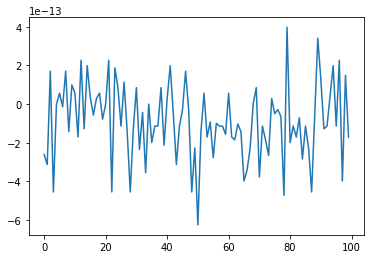

In [111]:
residual = model.resid
plt.plot(residual);

In [112]:
from scipy.stats import jarque_bera
test_stats, p = jarque_bera(residual)

print('Jarque-Bera Test')
print('test statistics: ', test_stats)
print('p-value: ', p)

Jarque-Bera Test
test statistics:  0.4195970257700933
p-value:  0.810747584706107


Since p-value in Jarque-Bera test and Omnibus test (omnibus normality test) are more than 0.05, the residuals might follow a normal distribution.

In the [Durbin-Watson test](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic), its test statistics is approximately $2(1-r)$ where $r$ is the autocorrelation of residuals.
In this case, since its test statistics is $1.794 \approx 2,$ we conclude that $r \approx 0,$ that is, residuals have almost zero autorcorrelation.

Heteroskedasticity tests: Breush-Pagan test and Goldfeld-Quandt test

In both tests, their null hypothesis is that all variances are the same.

In [122]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(residual, model.model.exog)
for x,y in zip(name, test):
  print(x,y)

Lagrange multiplier statistic 46.62157137255877
p-value 1.10630856968349e-06
f-value 7.773402025597682
f p-value 7.84389100883415e-09


Since p-values of F-statistics is less than 0.05, residuals have heteroskedasticity.

In [125]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residual, model.model.exog)
for x,y in zip(name, test):
  print(x,y)

F statistic 0.9060224092989445
p-value 0.620248204684311


Since the p-value is greater than 0.05, it suggests that residuals have equal variance.

After fitting a linear regression model, one can check its linearity using the Harvey-Collier multiplier test.

In [128]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(model)

/usr/local/lib/python3.6/dist-packages/statsmodels/sandbox/stats/diagnostic.py:1289: RuntimeWarning: invalid value encountered in sqrt
  rresid_scaled = rresid/np.sqrt(rvarraw)   #this is N(0,sigma2) distributed


It follows that the linear regression model satisfies all assumptions.

Useful regression diagnostic 
https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html#Heteroskedasticity-tests